# RSNA 2024 Lumbar Spine Degenerative Classification

## Data Loading

In [1]:
import os
import glob
import random
import gc
import math
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation, rc

import pydicom as dicom
from pydicom.pixels import apply_voi_lut

from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn   
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm
from einops import repeat
from fontTools.otlLib.builder import LOOKUP_FLAG_USE_MARK_FILTERING_SET

In [ ]:
# read data
# train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
train_path = 'drive/My Drive/RSNA_Kaggle_Project/'
# train_path = "/content/"

train  = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [ ]:
print("train shape :", train.shape)
print("train label shape :", label.shape)
print("train descriptions shape :", train_desc.shape)
print("test descriptions shape :", test_desc.shape)
print("submission shape :", sub.shape)

train shape : (1975, 26)
train label shape : (48692, 7)
train descriptions shape : (6294, 3)
test descriptions shape : (3, 3)
submission shape : (25, 4)


In [ ]:
# def number_of_images(directory):
#     return sum([len(files) for r, d, files in os.walk(directory) if any(f.endswith('.dcm') for f in files)])

# print("n of training images \t:", number_of_images(f'{train_path}/train_images'))
# print("n of test images \t:", number_of_images(f'{train_path}/test_images'))


# values with more than 4 series Id. They still have only 3 types of images.
# train_desc[train_desc['study_id'] == 10728036]
# train_desc[train_desc['study_id'] == 1009445512]

In [ ]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [ ]:
# number of images with at least one annotation
unique_count = label[['series_id', 'instance_number']].drop_duplicates().shape[0]
unique_count

24546

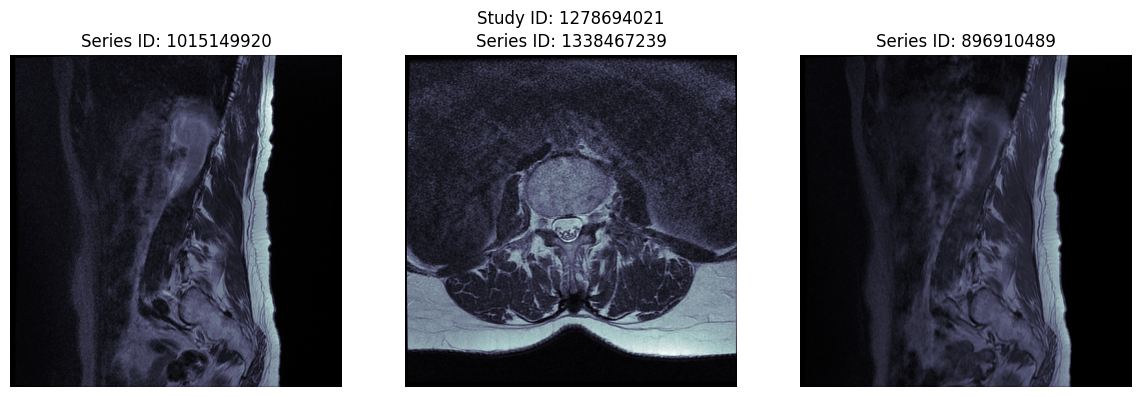

In [ ]:
def display_dicom_with_coordinates(study_id, image_paths, label_df, exact_image = True):

    fig, axs = plt.subplots(1, len(image_paths), figsize=(12,4))
    for index, (series_id, instance_number, path) in enumerate(image_paths):

        ds = dicom.dcmread(path)
        axs[index].imshow(ds.pixel_array, cmap=plt.cm.bone)
        axs[index].set_title(f'Series ID: {series_id}')
        axs[index].axis('off')

        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        if exact_image:
            filtered_labels = filtered_labels[filtered_labels['instance_number'] == instance_number]

        for _, row in filtered_labels.iterrows():
            axs[index].plot(row['x'], row['y'], 'ro', markersize = 3)

    fig.suptitle(f'Study ID: {study_id}')
    plt.tight_layout()
    plt.show()

study_id = train['study_id'].sample(n=1).iloc[0]
study_folder = f'{train_path}/train_images/{study_id}'
image_paths = []
for series_id in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_id)
    if not os.path.isdir(series_folder_path) : continue

    for f in os.listdir(series_folder_path):
        if f.endswith('.dcm'):
            file = f
            break

    instance_number = int(file.split('.')[0])
    image_paths.append((int(series_id), instance_number, os.path.join(series_folder_path, file)))

display_dicom_with_coordinates(int(study_id), image_paths, label)

## Data Preprocessing

In [ ]:
train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [ ]:
# converting the data to a long format with each study id having 25 rows
def reshape_row(row):
    data = {'study_id':[], 'condition':[], 'level':[], 'severity':[]}

    for column, value in row.items():
        if column not in ['study_id','series_id', 'instance_number', 'x', 'y', 'series_description']: # tidy elements : study_id는 그대로
            parts = column.split('_') # spinal_canal_stenosis_l1_l2 -> ['spinal', 'canal', 'stenosis', 'l1', 'l2']
            condition = ' '.join([word.capitalize() for word in parts[:-2]]) # ['spinal', 'canal', 'stenosis'] -> 'Spinal Canal Stenosis'
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize() # ['l1', 'l2'] -> 'L1/L2'
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)

    return pd.DataFrame(data)

new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

#validate if the size of long form is number of study id multiplied by 25
assert new_train_df.shape[0] == train.shape[0] * 25, 'Some issues with format conversion!'
new_train_df.head(26)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild


Now to see if we have specific images for each type.

In [ ]:
# new_train_df, label, train_desc
print("\nColumns in new_train_df:")
print(", ".join(new_train_df.columns))

print("\nColumns in label:")
print(", ".join(label.columns))

print("\nColumns in train_desc:")
print(", ".join(train_desc.columns))

print("\nColumns in sub:")
print(", ".join(sub.columns))


Columns in new_train_df:
study_id, condition, level, severity

Columns in label:
study_id, series_id, instance_number, condition, level, x, y

Columns in train_desc:
study_id, series_id, series_description

Columns in sub:
row_id, normal_mild, moderate, severe


In [ ]:
pd.crosstab([new_train_df['condition'], new_train_df['level']], new_train_df['severity'], margins=True)

severity                                Moderate  Normal/Mild  Severe    All
condition                        level                                      
Left Neural Foraminal Narrowing  L1/L2        63         1908       2   1973
                                 L2/L3       171         1791      11   1973
                                 L3/L4       411         1522      40   1973
                                 L4/L5       629         1204     140   1973
                                 L5/S1       520         1247     206   1973
Left Subarticular Stenosis       L1/L2        93         1690      28   1811
                                 L2/L3       255         1555      83   1893
                                 L3/L4       454         1324     194   1972
                                 L4/L5       624          887     461   1972
                                 L5/S1       409         1408     147   1964
Right Neural Foraminal Narrowing L1/L2        63         1891      13   1967
                                 L2/L3       168         1793       6   1967
                                 L3/L4       414         1512      41   1967
                                 L4/L5       629         1208     130   1967
                                 L5/S1       496         1281     190   1967
Right Subarticular Stenosis      L1/L2       110         1680      24   1814
                                 L2/L3       243         1577      73   1893
                                 L3/L4       454         1322     197   1973
                                 L4/L5       622          891     460   1973
                                 L5/S1       396         1399     173   1968
Spinal Canal Stenosis            L1/L2        67         1886      21   1974
                                 L2/L3       151         1770      53   1974
                                 L3/L4       230         1622     122   1974
                                 L4/L5       237         1482     255   1974
                                 L5/S1        51         1904      19   1974
All                                         7960        37754    3089  48803

To get more information about each type of image and what that image predicts, lets merge this with label and train_series_desc

In [ ]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [ ]:
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
print(final_merged_df.shape)
final_merged_df.head(25)

(48692, 9)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
5,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
6,4003253,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,12,191.321555,170.120141,Sagittal T1
7,4003253,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,1054713880,12,187.878354,217.245081,Sagittal T1
8,4003253,Left Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,11,186.504472,251.592129,Sagittal T1
9,4003253,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,11,197.100569,289.457306,Sagittal T1


In [ ]:
pd.crosstab(final_merged_df['condition'], final_merged_df['series_description'])

series_description,Axial T2,Sagittal T1,Sagittal T2/STIR
condition,,,
Left Neural Foraminal Narrowing,0,9860,0
Left Subarticular Stenosis,9608,0,0
Right Neural Foraminal Narrowing,0,9859,0
Right Subarticular Stenosis,9612,0,0
Spinal Canal Stenosis,0,5,9748


In [ ]:
final_merged_df['severity'].value_counts()

,count
severity,
Normal/Mild,37626
Moderate,7950
Severe,3081


In [ ]:
# there is a clear pattern of Conditions being Identified using a specific series
# lets delete the 5 series data that used sagittal T1 for predicting Spinal Canal Stenosis as exception.
df_filtered = final_merged_df[~((final_merged_df['condition'] == 'Spinal Canal Stenosis') & (final_merged_df['series_description'] == 'Sagittal T1'))]
final_merged_df = df_filtered
pd.crosstab(df_filtered['condition'], df_filtered['series_description'])

series_description,Axial T2,Sagittal T1,Sagittal T2/STIR
condition,,,
Left Neural Foraminal Narrowing,0,9860,0
Left Subarticular Stenosis,9608,0,0
Right Neural Foraminal Narrowing,0,9859,0
Right Subarticular Stenosis,9612,0,0
Spinal Canal Stenosis,0,0,9748


In [ ]:
final_merged_df['severity'].value_counts()

,count
severity,
Normal/Mild,37623
Moderate,7949
Severe,3080


In [ ]:
final_merged_df = final_merged_df.drop_duplicates(subset=['study_id', 'condition', 'series_id']).reset_index(drop=True)
print(final_merged_df.shape)
final_merged_df.head()

(10252, 9)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,11,196.070671,126.021201,Sagittal T1
2,4003253,Right Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,6,194.569790,127.755258,Sagittal T1
3,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2
4,4003253,Right Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,4,145.288771,158.624642,Axial T2


In [ ]:
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

print(final_merged_df.shape)
final_merged_df.head(5)

(10252, 10)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2
1,4003253,Left Neural Foraminal Narrowing,L1/L2,normal_mild,1054713880,11,196.070671,126.021201,Sagittal T1,4003253_left_neural_foraminal_narrowing_l1_l2
2,4003253,Right Neural Foraminal Narrowing,L1/L2,normal_mild,1054713880,6,194.569790,127.755258,Sagittal T1,4003253_right_neural_foraminal_narrowing_l1_l2
3,4003253,Left Subarticular Stenosis,L1/L2,normal_mild,2448190387,3,179.126448,161.235521,Axial T2,4003253_left_subarticular_stenosis_l1_l2
4,4003253,Right Subarticular Stenosis,L1/L2,normal_mild,2448190387,4,145.288771,158.624642,Axial T2,4003253_right_subarticular_stenosis_l1_l2


In [ ]:
# loop through the folder structure and get all the images


# Assuming df is your DataFrame and base_folder is your base directory
base_folder = train_path + "/train_images"

# Initialize an empty list to store new rows
rows = []

# Iterate through the DataFrame rows
for _, row in tqdm(final_merged_df.iterrows(), total=len(final_merged_df), desc="Processing rows"):
    series_id = row['series_id']
    study_id = row['study_id']

    # Construct the folder path
    folder_path = os.path.join(base_folder, str(study_id), str(series_id))

    # Get all .dcm files in that folder
    dcm_files = glob.glob(os.path.join(folder_path, "*.dcm"))

    # Create a new row for each .dcm file
    for dcm_file in dcm_files:
        new_row = row.copy()  # Keep other columns constant
        new_row['image_path'] = dcm_file  # Add the image path
        rows.append(new_row)  # Append the new row

# Create a new DataFrame with the expanded rows
final_merged_df_expanded = pd.DataFrame(rows)


Processing rows:   7%|▋         | 741/10252 [02:09<27:41,  5.72it/s]


KeyboardInterrupt: 

In [ ]:
print(final_merged_df_expanded.shape)
final_merged_df_expanded.head()
final_merged_df_expanded.to_csv(f'{train_path}/final_merged_df_expanded.csv', index=False)

NameError: name 'final_merged_df_expanded' is not defined

In [ ]:
final_merged_df = pd.read_csv(f'{train_path}/final_merged_df_expanded.csv')

## Test Description

In [ ]:
test_desc

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [ ]:
base_path = os.path.join(train_path, 'test_images')

def get_image_paths(row):
    series_folder_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_folder_path):
        return [os.path.join(series_folder_path, f) for f in os.listdir(series_folder_path) if f.endswith('.dcm')]
    else:
        print(f"Series path does not exist: {series_folder_path}")
    return []

condition_df = pd.DataFrame([
    {'series_description': 'Sagittal T1', 'condition': 'left_neural_foraminal_narrowing'},
    {'series_description': 'Sagittal T1', 'condition': 'right_neural_foraminal_narrowing'},
    {'series_description': 'Axial T2', 'condition': 'left_subarticular_stenosis'},
    {'series_description': 'Axial T2', 'condition': 'right_subarticular_stenosis'},
    {'series_description': 'Sagittal T2/STIR', 'condition': 'spinal_canal_stenosis'}
])

merged_df = pd.merge(test_desc, condition_df, on='series_description', how='left')
merged_df['image_paths'] = merged_df.apply(get_image_paths, axis=1)

expanded_test_desc = merged_df.explode('image_paths')
expanded_test_desc = expanded_test_desc.rename(columns={'image_paths': 'image_path'})
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: f"{row['study_id']}_{row['condition']}", axis=1)
expanded_test_desc  = expanded_test_desc.reset_index(drop=True)

expanded_test_desc.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing


In [ ]:
expanded_test_desc[['series_description', 'condition']].value_counts()

series_description  condition                       
Axial T2            left_subarticular_stenosis          47
                    right_subarticular_stenosis         47
Sagittal T1         left_neural_foraminal_narrowing     25
                    right_neural_foraminal_narrowing    25
Sagittal T2/STIR    spinal_canal_stenosis               25
Name: count, dtype: int64

In [ ]:
expanded_test_desc.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing


In [ ]:
train_data = final_merged_df
test_data = expanded_test_desc

print(f"\ntrain data shape: {train_data.shape}")
print(', '.join(train_data.columns))
print(f"\ntest data shape: {test_data.shape}")
print(', '.join(train_data.columns.intersection(test_data.columns))) #train_data.columns 순서대로 정렬

NameError: name 'final_merged_df' is not defined

In [ ]:
# MinMax scaling
def load_dicom(path):
    ds = dicom.dcmread(path)
    img = ds.pixel_array
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    img = (img * 255).astype(np.uint8)
    return img

NameError: name 'train_data' is not defined

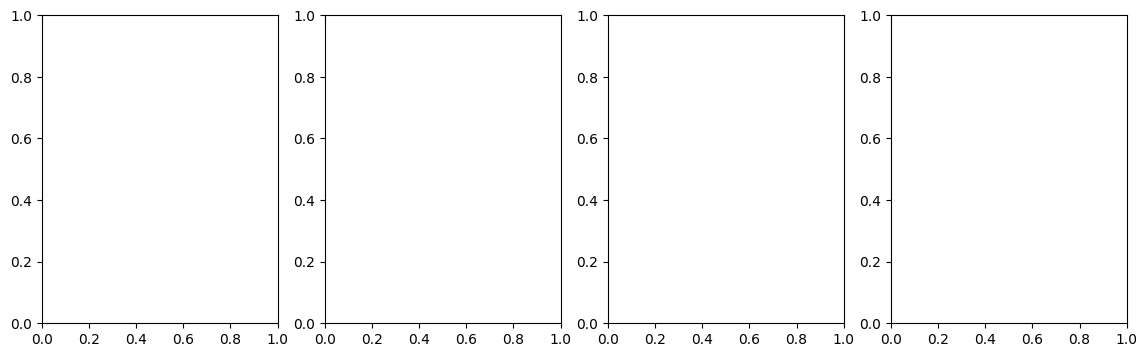

In [ ]:
# Plot images
fig, ax = plt.subplots(1, 4, figsize=(14, 4))
selected_indices = random.sample(range(len(train_data)), 4)
for c, i in enumerate(selected_indices):
    ax[c].imshow(load_dicom(train_data['image_path'][i]), cmap=plt.cm.bone)
    ax[c].set_title(f'Row ID: {train_data["row_id"][i]}', fontsize=8)
    ax[c].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(train_data.isna().sum(), "\n")
print(pd.crosstab(train_data['condition'], train_data['severity'].isna()))

study_id                0
condition               0
level                   0
severity              137
series_id               0
instance_number         0
x                       0
y                       0
series_description      0
row_id                  0
image_path              0
dtype: int64 

severity                          False  True 
condition                                     
Left Neural Foraminal Narrowing   33544      0
Left Subarticular Stenosis        73529     44
Right Neural Foraminal Narrowing  33451     93
Right Subarticular Stenosis       73294      0
Spinal Canal Stenosis             33554      0


In [ ]:
# Dropping the missing severity level
train_data = train_data.dropna()

In [ ]:
print(train_data.shape)
train_data.head()

(247372, 11)


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,drive/My Drive/RSNA_Kaggle_Project//train_imag...
1,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,drive/My Drive/RSNA_Kaggle_Project//train_imag...
2,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,drive/My Drive/RSNA_Kaggle_Project//train_imag...
3,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,drive/My Drive/RSNA_Kaggle_Project//train_imag...
4,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,drive/My Drive/RSNA_Kaggle_Project//train_imag...


# Making Custom Dataset Class

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.level_map = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1': 4}
        self.severity_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)
        if self.transform:
            image = self.transform(image)

        level = self.dataframe['level'][index]
        severity = self.dataframe['severity'][index]
        label = np.zeros(5, dtype=int)
        label[self.level_map[level]] = self.severity_map[severity]

        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=32):

    filtered_df = df[df['series_description'] == series_description]

    train_df, val_df = train_test_split(filtered_df, test_size=0.18, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)), # still not sure if I should keep this
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

Visualizing Sagittal T1 samples


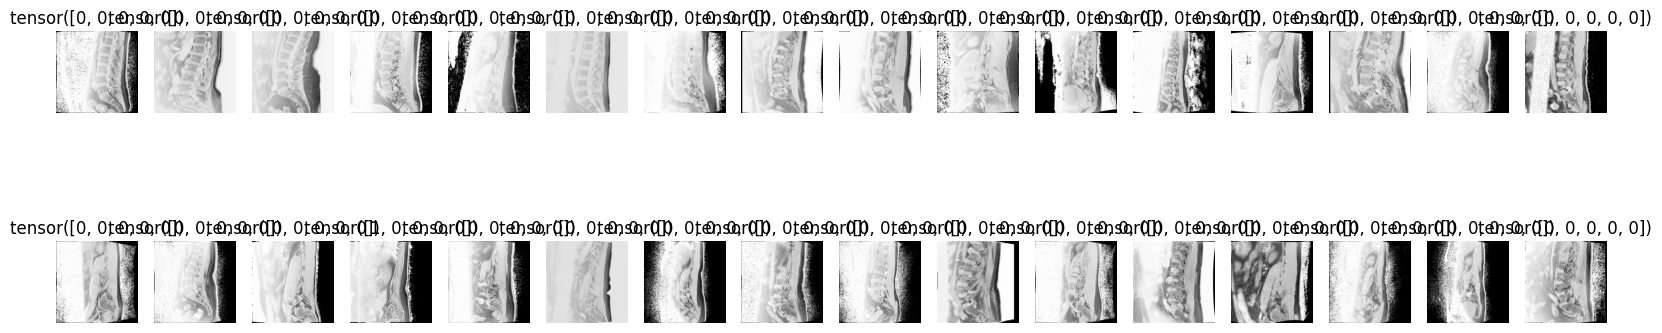

Visualizing Axial T2 samples


KeyboardInterrupt: 

In [ ]:
# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    n = len(images)//2
    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i//n][i%n]
        img = img.permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"{lbl}")
        ax.axis('off')
    plt.show()

# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2/STIR samples")
visualize_batch(trainloader_t2stir)

# Model

In [ ]:
class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""
    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)
        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)
        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """
        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)
        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""
        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))
            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

class S4D2D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, **kernel_args):
        super().__init__()
        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.D = nn.Parameter(torch.randn(self.h))
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout2d(dropout) if dropout > 0.0 else nn.Identity()
        self.output_linear = nn.Conv2d(self.h, self.h, kernel_size=1)

    def forward(self, u):
        # u shape: (B, H, H, W)
        B, C, H, W = u.shape
        u = u.reshape(B, C, H * W)

        L = H * W
        k = self.kernel(L=L)  # (H, L)
        k_f = torch.fft.rfft(k, n=2*L)  # (H, L)
        u_f = torch.fft.rfft(u, n=2*L)  # (B, H, L)
        y = torch.fft.irfft(u_f * k_f, n=2*L)[..., :L]  # (B, H, L)
        y = y + u * self.D.unsqueeze(-1)

        y = y.reshape(B, C, H, W)
        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        return y

class S4DImageProcessor2D(nn.Module):
    def __init__(self, in_channels, hidden_channels, d_state=64, s4_dropout=0.0):
        super().__init__()
        self.s4 = S4D2D(d_model=hidden_channels, d_state=d_state, dropout=s4_dropout)
        self.input_proj = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.output_proj = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.input_proj(x)
        x = self.s4(x)
        x = self.output_proj(x)
        return x

class EnsembleConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, dilation=2, n_conv_layers=3, d_state=64, s4_dropout=0.0):
        super().__init__()
        conv_3_list = []
        conv_5_list = []
        conv_7_list = []

        temp_in_channels = in_channels
        for _ in range(n_conv_layers):
            # convolution 3
            conv_3_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=3, padding=1))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, dilation=dilation, padding=(dilation * (3 - 1)) // 2))
            conv_3_list.append(nn.LeakyReLU(0.2))
            conv_3_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=3, dilation=dilation, padding=(dilation * (3 - 1)) // 2))
            conv_3_list.append(nn.LeakyReLU(0.2))


            # convolution 5
            conv_5_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=5, padding=2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, padding=2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, dilation=dilation, padding=(dilation * (5 - 1)) // 2))
            conv_5_list.append(nn.LeakyReLU(0.2))
            conv_5_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=5, dilation=dilation, padding=(dilation * (5 - 1)) // 2))
            conv_5_list.append(nn.LeakyReLU(0.2))

            # convolution 7
            conv_7_list.append(Conv2d(temp_in_channels, hidden_channels, kernel_size=7, padding=3))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, dilation=dilation, padding=(dilation * (7 - 1)) // 2))
            conv_7_list.append(nn.LeakyReLU(0.2))
            conv_7_list.append(Conv2d(hidden_channels, hidden_channels, kernel_size=7, dilation=dilation, padding=(dilation * (7 - 1)) // 2))
            conv_7_list.append(nn.LeakyReLU(0.2))

            temp_in_channels = hidden_channels

        self.conv3 = nn.Sequential(*conv_3_list)
        self.conv5 = nn.Sequential(*conv_5_list)
        self.conv7 = nn.Sequential(*conv_7_list)

        self.s4d = S4DImageProcessor2D(hidden_channels * 3, hidden_channels * 3, d_state=d_state, s4_dropout=s4_dropout)

        self.final_conv = nn.Conv2d(hidden_channels * 3, in_channels, kernel_size=3, padding=1)
        self.final_act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x_copy = x.clone()
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)

        x = torch.cat([x3, x5, x7], dim=1)
        x = self.s4d(x)
        x = self.final_act(self.final_conv(x))

        x = x + x_copy
        return x

In [ ]:
class LumbarClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, size=256,  n_conv_layers=2, d_state=64, s4_dropout=0.0):
        super().__init__()
        self.first_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.first_act = nn.LeakyReLU(0.2)

        # First Block
        self.s4_11 = EnsembleConv(hidden_channels, hidden_channels, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_12 = EnsembleConv(hidden_channels, hidden_channels, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_1 = nn.Conv2d(hidden_channels, hidden_channels * 2, stride=2, kernel_size=3, padding=1)

        # Second Block
        self.s4_21 = EnsembleConv(hidden_channels * 2, hidden_channels * 2, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_22 = EnsembleConv(hidden_channels * 2, hidden_channels * 2, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_2 = nn.Conv2d(hidden_channels * 2, hidden_channels * 4, stride=2, kernel_size=3, padding=1)

        # Third Block
        self.s4_31 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_32 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)
        self.downsample_3 = nn.Conv2d(hidden_channels * 4, hidden_channels * 4, stride=2, kernel_size=3, padding=1)

        # Fourth Block
        self.s4_41 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=2, n_conv_layers=n_conv_layers, d_state=d_state, s4_dropout=s4_dropout)
        self.s4_42 = EnsembleConv(hidden_channels * 4, hidden_channels * 4, dilation=4, n_conv_layers=n_conv_layers, d_state=d_state,
                                  s4_dropout=s4_dropout)

        # Features
        self.linear_1 = nn.Linear(hidden_channels * 4 * (size // 8) * (size // 8), hidden_channels)
        self.linear_2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear_3 = nn.Linear(hidden_channels, num_classes * 5)
        self.act = nn.LeakyReLU(0.2)

        self.num_classes = num_classes

    def forward(self, x):
        x = self.first_act(self.first_conv(x))

        # block 1
        x_copy = x.clone()
        x = self.s4_11(x)
        x = self.s4_12(x)
        x = x + x_copy
        x = self.downsample_1(x)

        # block 2
        x_copy = x.clone()
        x = self.s4_21(x)
        x = self.s4_22(x)
        x = x + x_copy
        x = self.downsample_2(x)

        # block 3
        x_copy = x.clone()
        x = self.s4_31(x)
        x = self.s4_32(x)
        x = x + x_copy
        x = self.downsample_3(x)

        # block 4
        x_copy = x.clone()
        x = self.s4_41(x)
        x = self.s4_42(x)
        x = x + x_copy

        # classifier
        x = x.flatten(1)
        x = self.act(self.linear_1(x))
        x = self.act(self.linear_2(x))
        x = self.linear_3(x)

        x = x.view(-1, 5, self.num_classes)
        return x


In [ ]:


def free_memory():
    # Delete all references to tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                del obj
        except:
            pass

    # Collect Python garbage
    gc.collect()

    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()

torch.cuda.empty_cache()
free_memory()
device = "cuda" if torch.cuda.is_available() else "cpu"
sagittal_t1_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)
axial_t2_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)
sagittal_t2stir_model = LumbarClassifier(in_channels=1, hidden_channels=32, num_classes=6,  size=224, n_conv_layers=2, d_state=32, s4_dropout=0.2).to(device)

# del x, lumbar
free_memory()

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
<ipython-input-27-2b0934090936>:5: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


In [ ]:
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3,pretrained_weights=None):
        super(CustomEfficientNetV2, self).__init__()
        self.model = models.efficientnet_v2_s(weights=None)
        self.num_classes = num_classes
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights, weights_only=True))

        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes * 5)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 5, self.num_classes)
        return x

    def unfreeze_model(self, num_unfreeze=2):
        for layer in list(self.model.features.children())[-num_unfreeze:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True

        for param in self.model.classifier.parameters():
            param.requires_grad = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# trainy_path =

weights_path = 'drive/My Drive/RSNA_Kaggle_Project/EfficientNet_v2.pth'

sagittal_t1_model = CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device)
axial_t2_model = CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device)
sagittal_t2stir_model = CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device)

cuda


In [ ]:
num_f_layers = len(list(sagittal_t1_model.model.features.children()))
print(f"The number of layers in self.model.features: {num_f_layers}")

num_f_layers = len(list(sagittal_t1_model.model.classifier.children()))
print(f"The number of layers in self.model.features: {num_f_layers}")

The number of layers in self.model.features: 8
The number of layers in self.model.features: 2


In [ ]:
for param in sagittal_t1_model.model.features.parameters():
    param.requires_grad = False
for param in axial_t2_model.model.features.parameters():
    param.requires_grad = False
for param in sagittal_t2stir_model.model.features.parameters():
    param.requires_grad = False

axial_t2_model.unfreeze_model(num_unfreeze=1)
sagittal_t2stir_model.unfreeze_model(num_unfreeze=1)

for param in sagittal_t1_model.model.classifier.parameters():
    param.requires_grad = True
for param in axial_t2_model.model.classifier.parameters():
    param.requires_grad = True
for param in sagittal_t2stir_model.model.classifier.parameters():
    param.requires_grad = True

 # 가중치 정의
def weighted_loss_function(outputs, labels, num_classes):
    if num_classes == 3:
        weights = torch.tensor([1.0, 2.5, 5.0]).to(device)
    else:
        weights = torch.tensor([1.0, 2.5, 5.0, 1.0, 2.5, 5.0]).to(device)
    loss = 0
    for i in range(5):
        loss_fn = nn.CrossEntropyLoss(weight=weights)
        loss += loss_fn(outputs[:, i, :], labels[:, i])
    return loss

optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.model.classifier.parameters(), lr=0.005)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.model.classifier.parameters(), lr=0.005)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.model.classifier.parameters(), lr=0.005)

custom_models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}

In [ ]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 38430


In [ ]:
def print_pytorch_model_summary(model, input_size=(3, 224, 224)):
    print(f"{'Layer Name':<30} {'Output Shape':<30} {'Param #':<15} {'Type':<15}")
    print("="*100)

    # Create a dummy input tensor with the specified input size
    dummy_input = torch.rand(1, *input_size).to(next(model.parameters()).device)

    # Forward pass through the model to get output shapes
    def register_hook(module, module_type):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            # Module name and output shape
            m_key = f"{class_name}-{module_idx + 1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters()),
                "type": module_type
            }

        if (
            not isinstance(module, nn.Sequential) and
            not isinstance(module, nn.ModuleList) and
            module != model
        ):
            hooks.append(module.register_forward_hook(hook))

    # Register hooks for features and classifier separately
    summary = {}
    hooks = []

    # Register hooks for feature extraction layers
    model.model.features.apply(lambda module: register_hook(module, "Feature Extraction"))

    # Register hooks for classifier layers
    model.model.classifier.apply(lambda module: register_hook(module, "Classifier"))

    # Perform a forward pass to collect output shapes
    model(dummy_input)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    total_params = 0
    for layer in summary:
        # Layer name
        print(f"{layer:<30} {str(summary[layer]['output_shape']):<30} {summary[layer]['nb_params']:<15} {summary[layer]['type']:<15}")
        total_params += summary[layer]["nb_params"]

    print("="*100)
    print(f"Total Params: {total_params}")

def count_layers(module):
    num_layers = 0
    for child in module.children():
        if isinstance(child, nn.Sequential):
            num_layers += count_layers(child)
        else:
            num_layers += 1
    return num_layers

num_f_layers = count_layers(sagittal_t1_model.model.features)
print(f"The number of layers in self.model.features: {num_f_layers}")

num_c_layers = count_layers(sagittal_t1_model.model.classifier)
print(f"The number of layers in self.model.classifier: {num_c_layers}")

The number of layers in self.model.features: 46
The number of layers in self.model.classifier: 2


# Training

In [ ]:
# # trainloader에서 불러온 입출력이 device로 정상적으로 전달되는지 체크
# for images, labels in trainloader_t2:
#     labels = labels.clone().detach().to(device)  # 이미 텐서인 경우 clone().detach()를 사용
#     labels = labels.to(device)  # 데이터를 GPU device로 할당

#     print(labels)
#     break

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=20, patience=3):
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0

        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.clone().detach().to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = weighted_loss_function(outputs, labels, model.num_classes)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()


                for i in range(5):
                    probabilities = torch.softmax(outputs[:, i, :], dim=1)
                    _, predicted = torch.max(probabilities, 1)
                    correct_train += (predicted == labels[:, i]).sum().item()

                tepoch.set_postfix(epoch=epoch+1)

        scheduler.step()


        train_loss /= len(trainloader)
        train_acc = 100*(correct_train/len_train)/5

        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), labels.clone().detach().to(device)
                    outputs = model(images)
                    loss = weighted_loss_function(outputs, labels, model.num_classes)
                    val_loss += loss.item()

                    for i in range(5):
                        probabilities = torch.softmax(outputs[:, i, :], dim=1)
                        _, predicted = torch.max(probabilities, 1)
                        correct_val += (predicted == labels[:, i]).sum().item()

                    vepoch.set_postfix(epoch=epoch+1)


        val_loss /= len(valloader)
        val_acc = 100*(correct_val/len_val)/5


        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1


        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break


    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [ ]:
# Training all models
for desc, model in custom_models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"Training model for {desc}")
    train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

# Inference

In [ ]:
train_data['level'].unique()

array(['L1/L2', 'L4/L5', 'L2/L3', 'L3/L4', 'L5/S1'], dtype=object)

In [ ]:
#test data에는 사진만 있고 level 정보가 없음
expanded_test_desc.head(5)

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing


In [ ]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

#row_id에 levels('l1_l2'~'l5_s1')을 붙여서 반환하는 함수
def update_row_id(row, levels): #인덱스 번호를 levels 리스트의 길이로 나눈 나머지를 계산하여 추가
    level = levels[row.name % len(levels)] #apply 함수 내에서 row.name은 현재 행의 인덱스 번호를 나타냄
    return f"{row['study_id']}_{row['condition']}_{level}"

#row_id에 levels를 붙여서 expanded_test_desc를 확장
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

NameError: name 'expanded_test_desc' is not defined

In [ ]:
expanded_test_desc.head()

,study_id,series_id,series_description,condition,image_path,row_id
0,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing_l2_l3
2,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing_l3_l4
3,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing_l4_l5
4,44036939,2828203845,Sagittal T1,left_neural_foraminal_narrowing,drive/My Drive/RSNA_Kaggle_Project/test_images...,44036939_left_neural_foraminal_narrowing_l5_s1


In [ ]:
expanded_test_desc[expanded_test_desc['series_description'] == 'Sagittal T2/STIR']['image_path'].str.split('/').str[-3:].str.join('/')

,image_path
144,44036939/3844393089/1.dcm
145,44036939/3844393089/10.dcm
146,44036939/3844393089/11.dcm
147,44036939/3844393089/12.dcm
148,44036939/3844393089/13.dcm
149,44036939/3844393089/14.dcm
150,44036939/3844393089/15.dcm
151,44036939/3844393089/16.dcm
152,44036939/3844393089/17.dcm
153,44036939/3844393089/18.dcm


In [ ]:
# Define a custom test dataset class
class TestDataset(Dataset):
    #instance = CustomDataset(test_data)
    #instance.dataframe -> dataframe
    #instance.transform -> transform
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    #len(instance) -> len(dataframe)
    def __len__(self):
        return len(self.dataframe)

    #instance[index] -> image, label
    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index] #인덱스를 통해 경로 호출
        image = load_dicom(image_path)  #경로로부터 DICOM image 로딩 #train과 달리 label은 없음!
        if self.transform:
            image = self.transform(image) #정의된 변환이 있을 경우 이미지에 변환 적용(리스케일 후 PyTorch Tensor로)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(expanded_test_desc, transform) #TestDataset에 expanded_test_desc를 넣어 이미지를 불러올 준비를 마침
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False) #batch_size=1으로 한 번에 하나의 샘플에 대해 예측을 수행DataLoader 객체 선언

In [ ]:
#(batch_size, channels, height, width)
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [ ]:
# custom_models = {
#     'Sagittal T1': CustomEfficientNetV2(num_classes=6, pretrained_weights=None).to(device),
#     'Axial T2': CustomEfficientNetV2(num_classes=6, pretrained_weights=None).to(device),
#     # 'Sagittal T2/STIR': sagittal_t2stir_model.load_state_dict(torch.load(f"{train_path}best_model.pth")),
# }
sagittal_t1_model.load_state_dict(torch.load(f'{train_path}Sagittal T1_mamba_best_model_2.pth', map_location=device, weights_only=True))
sagittal_t2stir_model.load_state_dict(torch.load(f'{train_path}Sagittal_T2_mamba_best_model_2.pth', map_location=device, weights_only=True))
axial_t2_model.load_state_dict(torch.load(f"{train_path}Axial T2_mamba_best_model_2.pth", map_location=device, weights_only=True))


custom_models = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}
# custom_models = {
#   'Sagittal T1': CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device),
#   'Axial T2': CustomEfficientNetV2(num_classes=6, pretrained_weights=weights_path).to(device),
#   'Sagittal T2/STIR': CustomEfficientNetV2(num_classes=3, pretrained_weights=weights_path).to(device),
# }

RuntimeError: Error(s) in loading state_dict for LumbarClassifier:
	Unexpected key(s) in state_dict: "s4_11.conv3.16.weight", "s4_11.conv3.16.bias", "s4_11.conv3.18.weight", "s4_11.conv3.18.bias", "s4_11.conv3.20.weight", "s4_11.conv3.20.bias", "s4_11.conv3.22.weight", "s4_11.conv3.22.bias", "s4_11.conv5.16.weight", "s4_11.conv5.16.bias", "s4_11.conv5.18.weight", "s4_11.conv5.18.bias", "s4_11.conv5.20.weight", "s4_11.conv5.20.bias", "s4_11.conv5.22.weight", "s4_11.conv5.22.bias", "s4_11.conv7.16.weight", "s4_11.conv7.16.bias", "s4_11.conv7.18.weight", "s4_11.conv7.18.bias", "s4_11.conv7.20.weight", "s4_11.conv7.20.bias", "s4_11.conv7.22.weight", "s4_11.conv7.22.bias", "s4_12.conv3.16.weight", "s4_12.conv3.16.bias", "s4_12.conv3.18.weight", "s4_12.conv3.18.bias", "s4_12.conv3.20.weight", "s4_12.conv3.20.bias", "s4_12.conv3.22.weight", "s4_12.conv3.22.bias", "s4_12.conv5.16.weight", "s4_12.conv5.16.bias", "s4_12.conv5.18.weight", "s4_12.conv5.18.bias", "s4_12.conv5.20.weight", "s4_12.conv5.20.bias", "s4_12.conv5.22.weight", "s4_12.conv5.22.bias", "s4_12.conv7.16.weight", "s4_12.conv7.16.bias", "s4_12.conv7.18.weight", "s4_12.conv7.18.bias", "s4_12.conv7.20.weight", "s4_12.conv7.20.bias", "s4_12.conv7.22.weight", "s4_12.conv7.22.bias", "s4_21.conv3.16.weight", "s4_21.conv3.16.bias", "s4_21.conv3.18.weight", "s4_21.conv3.18.bias", "s4_21.conv3.20.weight", "s4_21.conv3.20.bias", "s4_21.conv3.22.weight", "s4_21.conv3.22.bias", "s4_21.conv5.16.weight", "s4_21.conv5.16.bias", "s4_21.conv5.18.weight", "s4_21.conv5.18.bias", "s4_21.conv5.20.weight", "s4_21.conv5.20.bias", "s4_21.conv5.22.weight", "s4_21.conv5.22.bias", "s4_21.conv7.16.weight", "s4_21.conv7.16.bias", "s4_21.conv7.18.weight", "s4_21.conv7.18.bias", "s4_21.conv7.20.weight", "s4_21.conv7.20.bias", "s4_21.conv7.22.weight", "s4_21.conv7.22.bias", "s4_22.conv3.16.weight", "s4_22.conv3.16.bias", "s4_22.conv3.18.weight", "s4_22.conv3.18.bias", "s4_22.conv3.20.weight", "s4_22.conv3.20.bias", "s4_22.conv3.22.weight", "s4_22.conv3.22.bias", "s4_22.conv5.16.weight", "s4_22.conv5.16.bias", "s4_22.conv5.18.weight", "s4_22.conv5.18.bias", "s4_22.conv5.20.weight", "s4_22.conv5.20.bias", "s4_22.conv5.22.weight", "s4_22.conv5.22.bias", "s4_22.conv7.16.weight", "s4_22.conv7.16.bias", "s4_22.conv7.18.weight", "s4_22.conv7.18.bias", "s4_22.conv7.20.weight", "s4_22.conv7.20.bias", "s4_22.conv7.22.weight", "s4_22.conv7.22.bias", "s4_31.conv3.16.weight", "s4_31.conv3.16.bias", "s4_31.conv3.18.weight", "s4_31.conv3.18.bias", "s4_31.conv3.20.weight", "s4_31.conv3.20.bias", "s4_31.conv3.22.weight", "s4_31.conv3.22.bias", "s4_31.conv5.16.weight", "s4_31.conv5.16.bias", "s4_31.conv5.18.weight", "s4_31.conv5.18.bias", "s4_31.conv5.20.weight", "s4_31.conv5.20.bias", "s4_31.conv5.22.weight", "s4_31.conv5.22.bias", "s4_31.conv7.16.weight", "s4_31.conv7.16.bias", "s4_31.conv7.18.weight", "s4_31.conv7.18.bias", "s4_31.conv7.20.weight", "s4_31.conv7.20.bias", "s4_31.conv7.22.weight", "s4_31.conv7.22.bias", "s4_32.conv3.16.weight", "s4_32.conv3.16.bias", "s4_32.conv3.18.weight", "s4_32.conv3.18.bias", "s4_32.conv3.20.weight", "s4_32.conv3.20.bias", "s4_32.conv3.22.weight", "s4_32.conv3.22.bias", "s4_32.conv5.16.weight", "s4_32.conv5.16.bias", "s4_32.conv5.18.weight", "s4_32.conv5.18.bias", "s4_32.conv5.20.weight", "s4_32.conv5.20.bias", "s4_32.conv5.22.weight", "s4_32.conv5.22.bias", "s4_32.conv7.16.weight", "s4_32.conv7.16.bias", "s4_32.conv7.18.weight", "s4_32.conv7.18.bias", "s4_32.conv7.20.weight", "s4_32.conv7.20.bias", "s4_32.conv7.22.weight", "s4_32.conv7.22.bias", "s4_41.conv3.16.weight", "s4_41.conv3.16.bias", "s4_41.conv3.18.weight", "s4_41.conv3.18.bias", "s4_41.conv3.20.weight", "s4_41.conv3.20.bias", "s4_41.conv3.22.weight", "s4_41.conv3.22.bias", "s4_41.conv5.16.weight", "s4_41.conv5.16.bias", "s4_41.conv5.18.weight", "s4_41.conv5.18.bias", "s4_41.conv5.20.weight", "s4_41.conv5.20.bias", "s4_41.conv5.22.weight", "s4_41.conv5.22.bias", "s4_41.conv7.16.weight", "s4_41.conv7.16.bias", "s4_41.conv7.18.weight", "s4_41.conv7.18.bias", "s4_41.conv7.20.weight", "s4_41.conv7.20.bias", "s4_41.conv7.22.weight", "s4_41.conv7.22.bias", "s4_42.conv3.16.weight", "s4_42.conv3.16.bias", "s4_42.conv3.18.weight", "s4_42.conv3.18.bias", "s4_42.conv3.20.weight", "s4_42.conv3.20.bias", "s4_42.conv3.22.weight", "s4_42.conv3.22.bias", "s4_42.conv5.16.weight", "s4_42.conv5.16.bias", "s4_42.conv5.18.weight", "s4_42.conv5.18.bias", "s4_42.conv5.20.weight", "s4_42.conv5.20.bias", "s4_42.conv5.22.weight", "s4_42.conv5.22.bias", "s4_42.conv7.16.weight", "s4_42.conv7.16.bias", "s4_42.conv7.18.weight", "s4_42.conv7.18.bias", "s4_42.conv7.20.weight", "s4_42.conv7.20.bias", "s4_42.conv7.22.weight", "s4_42.conv7.22.bias". 
	size mismatch for first_conv.weight: copying a param with shape torch.Size([8, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for first_conv.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.0.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.2.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.4.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.6.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.8.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.10.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.12.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv3.14.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_11.conv3.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.0.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.2.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.4.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.6.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.8.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.10.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.12.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv5.14.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_11.conv5.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.0.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.2.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.4.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.6.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.8.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.10.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.12.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.conv7.14.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_11.conv7.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_11.s4d.s4.D: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_11.s4d.s4.kernel.C: copying a param with shape torch.Size([24, 8, 2]) from checkpoint, the shape in current model is torch.Size([96, 16, 2]).
	size mismatch for s4_11.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_11.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([24, 8]) from checkpoint, the shape in current model is torch.Size([96, 16]).
	size mismatch for s4_11.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([24, 8]) from checkpoint, the shape in current model is torch.Size([96, 16]).
	size mismatch for s4_11.s4d.s4.output_linear.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_11.s4d.s4.output_linear.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_11.s4d.input_proj.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_11.s4d.input_proj.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_11.s4d.output_proj.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_11.s4d.output_proj.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_11.final_conv.weight: copying a param with shape torch.Size([8, 24, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 96, 3, 3]).
	size mismatch for s4_11.final_conv.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.0.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.2.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.4.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.6.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.8.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.10.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.12.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv3.14.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for s4_12.conv3.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.0.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.2.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.4.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.6.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.8.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.10.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.12.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv5.14.weight: copying a param with shape torch.Size([8, 8, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 32, 5, 5]).
	size mismatch for s4_12.conv5.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.0.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.2.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.4.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.4.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.6.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.6.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.8.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.8.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.10.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.10.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.12.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.12.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.conv7.14.weight: copying a param with shape torch.Size([8, 8, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 32, 7, 7]).
	size mismatch for s4_12.conv7.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for s4_12.s4d.s4.D: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_12.s4d.s4.kernel.C: copying a param with shape torch.Size([24, 8, 2]) from checkpoint, the shape in current model is torch.Size([96, 16, 2]).
	size mismatch for s4_12.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_12.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([24, 8]) from checkpoint, the shape in current model is torch.Size([96, 16]).
	size mismatch for s4_12.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([24, 8]) from checkpoint, the shape in current model is torch.Size([96, 16]).
	size mismatch for s4_12.s4d.s4.output_linear.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_12.s4d.s4.output_linear.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_12.s4d.input_proj.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_12.s4d.input_proj.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_12.s4d.output_proj.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 96, 1, 1]).
	size mismatch for s4_12.s4d.output_proj.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for s4_12.final_conv.weight: copying a param with shape torch.Size([8, 24, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 96, 3, 3]).
	size mismatch for s4_12.final_conv.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for downsample_1.weight: copying a param with shape torch.Size([16, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for downsample_1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.0.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.2.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.4.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.6.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.8.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.10.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.12.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv3.14.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_21.conv3.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.0.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.2.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.4.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.6.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.8.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.10.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.12.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv5.14.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_21.conv5.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.0.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.2.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.4.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.6.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.8.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.10.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.12.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.conv7.14.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_21.conv7.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_21.s4d.s4.D: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_21.s4d.s4.kernel.C: copying a param with shape torch.Size([48, 8, 2]) from checkpoint, the shape in current model is torch.Size([192, 16, 2]).
	size mismatch for s4_21.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_21.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([48, 8]) from checkpoint, the shape in current model is torch.Size([192, 16]).
	size mismatch for s4_21.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([48, 8]) from checkpoint, the shape in current model is torch.Size([192, 16]).
	size mismatch for s4_21.s4d.s4.output_linear.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_21.s4d.s4.output_linear.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_21.s4d.input_proj.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_21.s4d.input_proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_21.s4d.output_proj.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_21.s4d.output_proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_21.final_conv.weight: copying a param with shape torch.Size([16, 48, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 192, 3, 3]).
	size mismatch for s4_21.final_conv.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.0.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.2.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.4.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.6.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.8.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.10.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.12.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv3.14.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for s4_22.conv3.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.0.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.2.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.4.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.6.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.8.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.10.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.12.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv5.14.weight: copying a param with shape torch.Size([16, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 5, 5]).
	size mismatch for s4_22.conv5.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.0.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.2.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.4.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.6.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.6.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.8.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.10.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.10.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.12.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.12.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.conv7.14.weight: copying a param with shape torch.Size([16, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 64, 7, 7]).
	size mismatch for s4_22.conv7.14.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for s4_22.s4d.s4.D: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_22.s4d.s4.kernel.C: copying a param with shape torch.Size([48, 8, 2]) from checkpoint, the shape in current model is torch.Size([192, 16, 2]).
	size mismatch for s4_22.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_22.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([48, 8]) from checkpoint, the shape in current model is torch.Size([192, 16]).
	size mismatch for s4_22.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([48, 8]) from checkpoint, the shape in current model is torch.Size([192, 16]).
	size mismatch for s4_22.s4d.s4.output_linear.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_22.s4d.s4.output_linear.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_22.s4d.input_proj.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_22.s4d.input_proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_22.s4d.output_proj.weight: copying a param with shape torch.Size([48, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 192, 1, 1]).
	size mismatch for s4_22.s4d.output_proj.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for s4_22.final_conv.weight: copying a param with shape torch.Size([16, 48, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 192, 3, 3]).
	size mismatch for s4_22.final_conv.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for downsample_2.weight: copying a param with shape torch.Size([32, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for downsample_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.4.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.6.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.8.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.10.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.12.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv3.14.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_31.conv3.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.0.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.2.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.4.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.6.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.8.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.10.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.12.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv5.14.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_31.conv5.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.0.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.2.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.4.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.6.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.8.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.10.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.12.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.conv7.14.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_31.conv7.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_31.s4d.s4.D: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_31.s4d.s4.kernel.C: copying a param with shape torch.Size([96, 8, 2]) from checkpoint, the shape in current model is torch.Size([384, 16, 2]).
	size mismatch for s4_31.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_31.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_31.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_31.s4d.s4.output_linear.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_31.s4d.s4.output_linear.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_31.s4d.input_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_31.s4d.input_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_31.s4d.output_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_31.s4d.output_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_31.final_conv.weight: copying a param with shape torch.Size([32, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for s4_31.final_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.4.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.6.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.8.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.10.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.12.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv3.14.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_32.conv3.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.0.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.2.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.4.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.6.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.8.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.10.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.12.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv5.14.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_32.conv5.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.0.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.2.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.4.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.6.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.8.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.10.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.12.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.conv7.14.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_32.conv7.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_32.s4d.s4.D: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_32.s4d.s4.kernel.C: copying a param with shape torch.Size([96, 8, 2]) from checkpoint, the shape in current model is torch.Size([384, 16, 2]).
	size mismatch for s4_32.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_32.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_32.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_32.s4d.s4.output_linear.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_32.s4d.s4.output_linear.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_32.s4d.input_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_32.s4d.input_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_32.s4d.output_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_32.s4d.output_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_32.final_conv.weight: copying a param with shape torch.Size([32, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for s4_32.final_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for downsample_3.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for downsample_3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.4.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.6.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.8.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.10.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.12.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv3.14.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_41.conv3.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.0.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.2.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.4.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.6.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.8.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.10.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.12.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv5.14.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_41.conv5.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.0.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.2.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.4.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.6.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.8.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.10.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.12.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.conv7.14.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_41.conv7.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_41.s4d.s4.D: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_41.s4d.s4.kernel.C: copying a param with shape torch.Size([96, 8, 2]) from checkpoint, the shape in current model is torch.Size([384, 16, 2]).
	size mismatch for s4_41.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_41.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_41.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_41.s4d.s4.output_linear.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_41.s4d.s4.output_linear.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_41.s4d.input_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_41.s4d.input_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_41.s4d.output_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_41.s4d.output_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_41.final_conv.weight: copying a param with shape torch.Size([32, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for s4_41.final_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.2.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.4.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.6.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.8.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.10.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.12.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv3.14.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for s4_42.conv3.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.0.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.2.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.4.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.6.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.8.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.10.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.12.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv5.14.weight: copying a param with shape torch.Size([32, 32, 5, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 5, 5]).
	size mismatch for s4_42.conv5.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.0.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.2.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.4.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.6.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.8.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.8.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.10.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.12.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.12.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.conv7.14.weight: copying a param with shape torch.Size([32, 32, 7, 7]) from checkpoint, the shape in current model is torch.Size([128, 128, 7, 7]).
	size mismatch for s4_42.conv7.14.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for s4_42.s4d.s4.D: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_42.s4d.s4.kernel.C: copying a param with shape torch.Size([96, 8, 2]) from checkpoint, the shape in current model is torch.Size([384, 16, 2]).
	size mismatch for s4_42.s4d.s4.kernel.log_dt: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_42.s4d.s4.kernel.log_A_real: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_42.s4d.s4.kernel.A_imag: copying a param with shape torch.Size([96, 8]) from checkpoint, the shape in current model is torch.Size([384, 16]).
	size mismatch for s4_42.s4d.s4.output_linear.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_42.s4d.s4.output_linear.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_42.s4d.input_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_42.s4d.input_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_42.s4d.output_proj.weight: copying a param with shape torch.Size([96, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([384, 384, 1, 1]).
	size mismatch for s4_42.s4d.output_proj.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for s4_42.final_conv.weight: copying a param with shape torch.Size([32, 96, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for s4_42.final_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for linear_1.weight: copying a param with shape torch.Size([8, 25088]) from checkpoint, the shape in current model is torch.Size([32, 100352]).
	size mismatch for linear_1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for linear_2.weight: copying a param with shape torch.Size([8, 8]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for linear_2.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for linear_3.weight: copying a param with shape torch.Size([30, 8]) from checkpoint, the shape in current model is torch.Size([30, 32]).

In [ ]:
 def get_model(series_description):
    return custom_models.get(series_description, None)

def predict_test_data(testloader, expanded_test_desc):
    predictions = []

    for model in custom_models.values():
        model.eval()

    with torch.no_grad():
        total_index = 0
        for images in tqdm(testloader):
            images = images.to(device)
            batch_size = images.size(0)

            for i in range(batch_size):
                series_description = expanded_test_desc.iloc[total_index]['series_description']
                model = get_model(series_description)
                if model:
                    outputs = model(images[i].unsqueeze(0))
                    probs = torch.softmax(outputs, dim=2).squeeze(0)

                    level_predictions = []
                    for level_idx in range(5):
                        level_predictions.append({
                            'normal_mild': probs[level_idx, 0].item(),
                            'moderate': probs[level_idx, 1].item(),
                            'severe': probs[level_idx, 2].item(),
                            'level': level_idx,
                            'series_description': series_description
                        })
                    predictions.append(level_predictions)
                else:
                    predictions.append([{'normal_mild': None, 'moderate': None, 'severe': None, 'level': None, 'condition': None}] * 5)

                total_index += 1

    return predictions


In [ ]:
results = predict_test_data(testloader, expanded_test_desc)

results_df = pd.DataFrame()

for result in results:
    row = pd.DataFrame(result)
    results_df = pd.concat([results_df, row])

100%|██████████| 169/169 [02:05<00:00,  1.35it/s]


In [ ]:
results_df.head()

,normal_mild,moderate,severe,level,series_description
0,0.871027,0.114465,0.009951,0,Sagittal T1
1,0.994457,0.001393,0.000705,1,Sagittal T1
2,0.995981,0.000893,0.001013,2,Sagittal T1
3,0.994659,0.001101,0.000801,3,Sagittal T1
4,0.994407,0.001040,0.001096,4,Sagittal T1


In [ ]:
condition_df = pd.DataFrame([
    {'series_description': 'Sagittal T1', 'condition': 'left_neural_foraminal_narrowing'},
    {'series_description': 'Sagittal T1', 'condition': 'right_neural_foraminal_narrowing'},
    {'series_description': 'Axial T2', 'condition': 'left_subarticular_stenosis'},
    {'series_description': 'Axial T2', 'condition': 'right_subarticular_stenosis'},
    {'series_description': 'Sagittal T2/STIR', 'condition': 'spinal_canal_stenosis'}
])

results_df_with_condition = pd.merge(results_df, condition_df, on='series_description', how='left')
results_df_with_condition.head()

inverse_level_map = {0 : 'l1_l2', 1:'l2_l3', 2: 'l3_l4', 3: 'l4_l5', 4: 'l5_s1'}
results_df_with_condition['level'] = results_df_with_condition['level'].map(inverse_level_map)
results_df_with_condition['row_id'] = "44036939_" + results_df_with_condition['condition'] + "_" + results_df_with_condition['level']
results_df_with_condition = results_df_with_condition[['row_id', 'normal_mild', 'moderate', 'severe']]

In [ ]:
submission = results_df_with_condition.groupby('row_id').mean().reset_index()

row_sum = submission[['normal_mild', 'moderate', 'severe']].sum(axis=1)

submission.to_csv("/kaggle/working/submission.csv", index=False)